# Audio Classification With Deep Learning Using Librosa & Keras
## Graham Bachman
### Synopsis: 
In this project I will be exploring a technique for working with audio clips in deep learning. Specifically, the transformation of a collection of raw audio files into a set of spectrogram images (a visualization of sound that plots time against frequency and applies a heat map for amplitude), and training a convolutional neural network on the spectrogram images. The goal is to train a model that can successfully categorize sounds. In this particular challenge, the data is very diverse and naturally lends itself to an exploration of general purpose audio classification. That is, machines that can realibly classify a wide range of real-world sounds - as might be collected in environment monitoring. A potential application of this sort of model (or at least of the technique here demonstrated) is the monitoring of certain species' populations in various natural habitats. 

The original paper from the DCASE 2018 Challenge: https://arxiv.org/pdf/1807.09902v1.pdf

My best submission scored a 0.82170, which puts me in the 280th positon on the leaderboard.

## Import Packages

In [1]:
# Standard
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import gc
import shutil
import seaborn as sns

# Deep Learning
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import *
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Librosa is a package that simplifies audio processing and visualizing in python
import librosa
import librosa.display

# using this package to play audio files in the kaggle notebook
import IPython
import IPython.display as ipd

## Loading Data

Create dataframes for the training and testing data and get the shape of both. We see there are 9473 files from the training set, and 9400 from the testing

In [2]:
path = '../input/freesound-audio-tagging/'
train_path = path + 'audio_train/'

print(len(os.listdir(train_path)))

9473


In [3]:
train = pd.read_csv("../input/freesound-audio-tagging/train.csv")
test = pd.read_csv("../input/freesound-audio-tagging/sample_submission.csv")

print('Train Shape:', train.shape)
print('Test Shape: ', test.shape)
train.head()

Train Shape: (9473, 3)
Test Shape:  (9400, 2)


,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


It will be useful to see how many different types of sounds are present in the data, for which we will have to predict labels. There are 41 unique sounds and are listed below.

In [4]:
uniq_labels = train.label.unique()
print('Unique Labels:',len(uniq_labels))
print()
print(uniq_labels)

Unique Labels: 41

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


Not all the labels given in the test set were manually verified, the graph below shows the amount of manually verified labels there are for each category of sound and the amount of clips belonging to each category. 

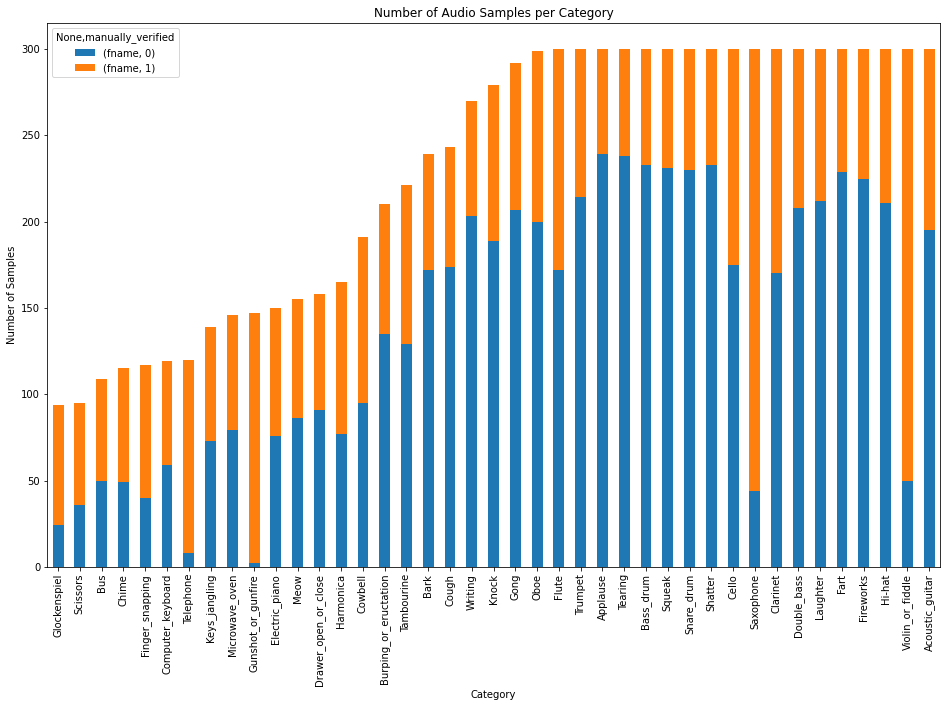

In [5]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [6]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


## Brief Background on Spectrogram Images

### Analog Digital Conversion (ADC):
Acoustic waveforms (sounds) are continuous, we need them digitized/countable to work with them. ADC outlines a two-step process for doing this.
1. Sampling - at a specified interval, we measure the amplitude of the waveform. This is usually done several thousands of times every second. This implies some error, defined as the difference between the area under the curve of the wave, and the area of the (imagined) vertical bars that represent the sampling interval. The error is minimized by using a higher sampling rate.
2. Quantization - We have a discrete/fixed number of values for amplitude on the y-axis (we can make it more or less). At every sampled measure of the waveform's amplitude, we approximate the amplitude to the closest value we have on the y-axis. This implies some error, defined as the difference between the actual amplitude and the approximated amplitude. The error is minimized the more bits that are used. The values on the y-axis are a sequence of ascending binary values. 4 bits means 4 binary values (4 bits = 0000, 5 bits = 00000...). The more bits, the more values on the y-axis and the smaller the error. A CD is 16 bits.
The result of ADC is signal (also sometimes referred to as pulse-code modulation)
Signal will be a one-dimensional numpy array containing some # of values that are equal to sample_rate T (duration of the audio clip) Here the length of the clip is one minute so signal is 22050 60
sr is the sampling rate -> how many times per second that the amplitude of the sound wave is sampled. 22050 is sort of a standard sampling rate (what's used on CD's) and it's slightly above the human hearing range - so we can appreciate the whole frequency range in this audio clip.

### Listen to one of the files

In [7]:
file = '../input/freesound-audio-tagging/audio_train/00044347.wav'
ipd.Audio(file)

In [8]:
signal, sr = librosa.load(file, sr=22050)

### Visualize the sound recording as a waveform

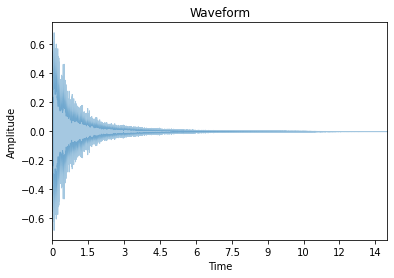

In [9]:
plt.figure()
librosa.display.waveplot(signal, sr, alpha=0.4)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

### The Fourier Transform:
At a high-level, the fourier transform is a mathematical way to 'unpack' a complex waveform into the many simpler waves that comprise it. Here's a video for more: https://www.youtube.com/watch?v=spUNpyF58BY

We use the below cell to perform a Fourier Transform (fft = fast fourier transform), transitioning out of the time domain and into the frequency domain.

The result is a numpy array with as many values as the total number of samples we have in the waveform (22050 * 60). We then need to get the absolute value of fft to deal with the complex numbers produced by running the transform. This new magnitude object indicates the contribution of each frequency bin to the overall sound.

Finally we map the magnitude to the relative frequency bins. What we end up with are two arrays. Magnitude has the values of each frequency bin, and spectrum has all the possible values for frequency defined by our sampling rate (0 to 22050).

Plot the power spectrum - visualizes the fourier transform of our waveform. The power specturm is symmentrical, and therefore a little redudant, we only need consider the first half of the plot.¶


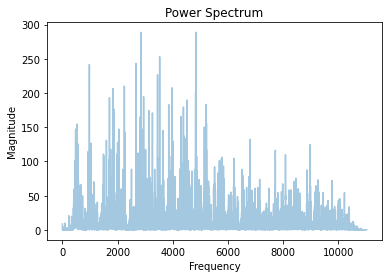

In [10]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
spectrum = np.linspace(0, sr, len(magnitude))
left_spec = spectrum[:int(len(spectrum)/2)]
left_mag = magnitude[:int(len(spectrum)/2)]

plt.plot(left_spec, left_mag, alpha=0.4)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum')
plt.show()

We can now see which frequencies contribute the most energy to the sound.

### The Short-Time Fourier Transform:
There is a caveat to the fourier transform; by making the transform, we switch from time to hertz - the entire length of the recording is summarized in a single 'snapshot,' measured with amplitude on the y-axis and frequency (in hertz) on the x-axis. In other words, we lose time, and with it the opportunity to see how the wave changes over the course of the clip.

To solve this, we run the discrete fourier transform over smaller segments or frames of the wave. Run the transform, slide the frame, run it again, slide the frame...
The result is a spectrogram, a (heat map) visualization of a waveform in three dimensions, time on the x-axis, frequency on the y-axis and amplitude (dBFS) in color intensity. It shows amplitude as a function of time and frequency.

We can feed a spectrogram into a model for training.

We define n_fft as the window (# of samples) that we are considering when applying a single fft. hop_len is the number of samples that we will slide over to apply the next fft.
Apply absolute value to stft to fix complex numbers. Then calculate the log spectrogram. The log spectrogram takes the amplitude values from the original spectrogram and converts them to decibels (a logarithm is used to do this, humans perceive frequency logarithmically).¶

### Plot the spectrogram.


(128, 38)


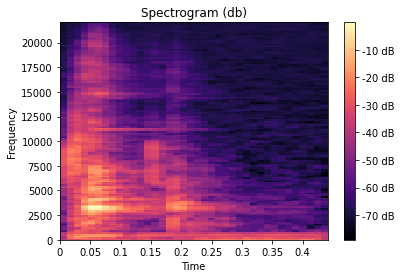

In [11]:
fname = train_path + '002d256b.wav'

hop_length = 512

clip, sr = librosa.load(fname, sr=44100)

S1 = librosa.feature.melspectrogram(y=clip, sr=44100)   
S2 = librosa.power_to_db(S1, ref=np.max)                

print(S2.shape)

librosa.display.specshow(S2, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format="%+2.0f dB")
plt.title('Spectrogram (db)')
plt.show()

### Generate spectrograms for the first 16 files.

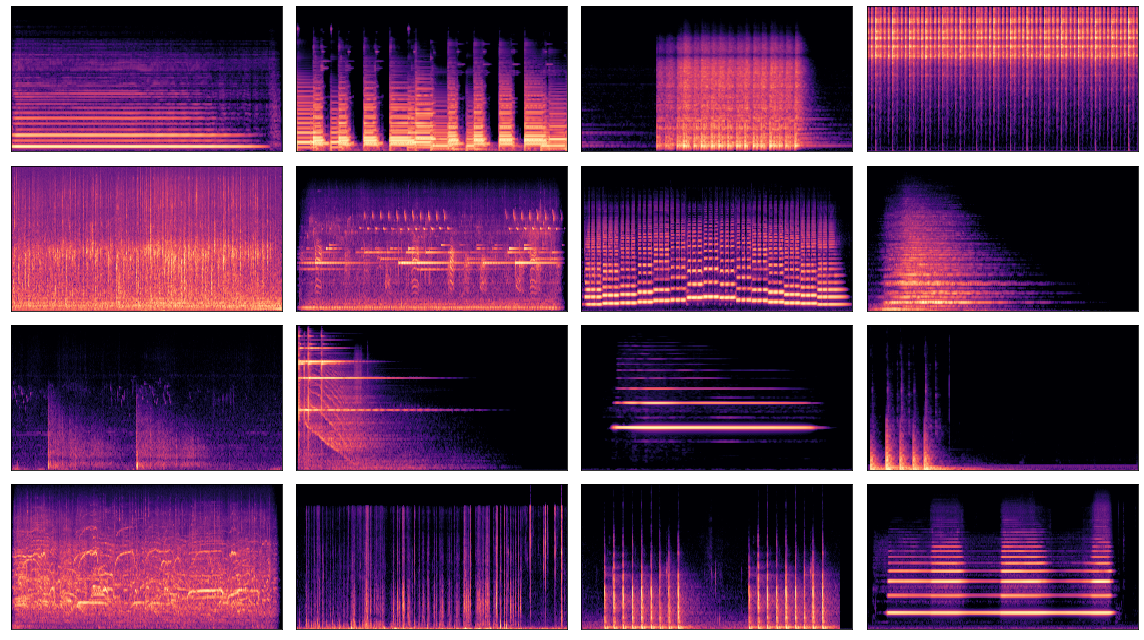

In [12]:
sample = train.sample(16)

plt.figure(figsize=[16,9])

for i in range(16):
    fname = train_path + sample.fname.iloc[i]
    clip, sr = librosa.load(fname, sr=44100)
    S1 = librosa.feature.melspectrogram(y=clip, sr=44100)   
    S2 = librosa.power_to_db(S1, ref=np.max)                
    
    plt.subplot(4, 4, i+1)
    librosa.display.specshow(S2)

plt.tight_layout()
plt.show()

## Create Spectrogram Images
Now that we know a little more about the theory behind spectrogram images, let's generate them for each recording in the dataset. This is the data we will train our model on.

In [13]:
# Create directory
!mkdir train_images
!mkdir test_images

In [14]:
# Define function for creating spectrogram image
def create_spectrogram_file(fname, source, dest, dpi):
    
    path = source + fname
    save_path  = dest + fname[:-4] + '.jpg'
    
    clip, sr = librosa.load(path, sr=44100)
    
    S1 = librosa.feature.melspectrogram(y=clip, sr=44100)
    S2 = librosa.power_to_db(S1, ref=np.max)
    
    fig = plt.figure()
    librosa.display.specshow(S2)   
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight',pad_inches=0)
    
    plt.cla()
    plt.clf()
    plt.close('all')
    plt.close(fig)
    del S1, S2, clip, fig
    gc.collect()

In the interest of getting a save and run all version of this notebook in a timely manner, I am commenting the cells below out. The images have been previously generated and it doesn't make sense to generate them again - especially if it means adding a significant run time.

In [15]:
# Generate the images
#%%time

#start = 0
#end = 10000
#n = start

#source = train_path
#dest = 'train_images/'

#for f in train.fname.values[start:end]:
#    create_spectrogram_file(f, source, dest, 50)
#    n += 1
    
#    if n % 50 == 0:
#        print(n, end=' ')
    
#    if n % 1000 == 0:
#        gc.collect()

In [16]:
#train['image_file'] = train.fname.apply(lambda x : x[:-4] + '.jpg')
#test['image_file'] = test.fname.apply(lambda x : x[:-4] + '.jpg')

#le = LabelEncoder()
#le.fit(train.label)

#train['enc_label'] = le.transform(train.label)
#test['enc_label'] = le.transform(test.label)

## Data Generators
Now that we've created the spectrogram images, we need to run a Image Data Generator to get the data into a set that we can train on.

In [17]:
# Load DataFrame for Training Data
train_df = pd.read_csv('../input/freesound-audio-tagging/train.csv')

# The file names are put down as .wav files, apply a function to change them to .jpg so they can be looked up in the spectrogram img dataset
train_df['img_name'] = train_df.fname.apply(lambda x : x[:-4] + '.jpg')
train_df.head()

,fname,label,manually_verified,img_name
0,00044347.wav,Hi-hat,0,00044347.jpg
1,001ca53d.wav,Saxophone,1,001ca53d.jpg
2,002d256b.wav,Trumpet,0,002d256b.jpg
3,0033e230.wav,Glockenspiel,1,0033e230.jpg
4,00353774.wav,Cello,1,00353774.jpg


In [18]:
# Initialize ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# Define variables
batch_size = 64
target_size = (50,75)

# Create training set
training_gen = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = '../input/freesound-2018-100dpi/train_images/',
    subset = "training",
    x_col = 'img_name',
    y_col = 'label',
    shuffle = True,
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = target_size
)

# Create validation set
validation_gen = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = '../input/freesound-2018-100dpi/train_images',
    subset = "validation",
    x_col = 'img_name',
    y_col = 'label',
    shuffle = True,
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = target_size
)

Found 7579 validated image filenames belonging to 41 classes.
Found 1894 validated image filenames belonging to 41 classes.


In [19]:
tr_batches = len(training_gen)
va_batches = len(validation_gen)

## Design & Train CNN
### Model 1
For the sake of efficiency, I am only including my best Sequential model in this notebook. I trained several other models that were conceptually similar to this one, but had some variation that produced different results. Over the course of my training I experimented with varying amounts of layers, more aggressive dropouts, different optimizers, different learning rates and different number of epochs. The model below was the best performing of the bunch, and serves as a representative of the other models that were trained. 

In [20]:
# Design CNN
model_1 = Sequential([
      Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', input_shape=(50,75,3)),
      Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=2),
      Dropout(0.2),
      BatchNormalization(),
    
      Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=2),
      Dropout(0.4),
      BatchNormalization(),
    
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.6),
      BatchNormalization(),
    
      Dense(256, activation='relu'),
      Dropout(0.8),
      BatchNormalization(),
    
      Dense(41, activation='softmax'),   
])

# Show model summary
model_1.summary()

# Define optimizer
opt = keras.optimizers.Adam(0.0001)

# Compile the model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 75, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 75, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 37, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 37, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 37, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 37, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 37, 256)       5

#### Train the model

In [21]:
%%time 

epochs = 50

history_1 = model_1.fit(training_gen, steps_per_epoch=tr_batches, validation_data = validation_gen, validation_steps=va_batches, verbose=1, epochs=epochs)

Epoch 1/50
119/119 [==============================] - 56s 434ms/step - loss: 4.3278 - accuracy: 0.0348 - val_loss: 3.7339 - val_accuracy: 0.0269
Epoch 2/50
119/119 [==============================] - 29s 248ms/step - loss: 4.0473 - accuracy: 0.0590 - val_loss: 3.7576 - val_accuracy: 0.0269
Epoch 3/50
119/119 [==============================] - 31s 263ms/step - loss: 3.8650 - accuracy: 0.0743 - val_loss: 3.6862 - val_accuracy: 0.0269
Epoch 4/50
119/119 [==============================] - 29s 246ms/step - loss: 3.6548 - accuracy: 0.0955 - val_loss: 3.3513 - val_accuracy: 0.1309
Epoch 5/50
119/119 [==============================] - 29s 247ms/step - loss: 3.5381 - accuracy: 0.1156 - val_loss: 3.1336 - val_accuracy: 0.1948
Epoch 6/50
119/119 [==============================] - 29s 247ms/step - loss: 3.4468 - accuracy: 0.1237 - val_loss: 2.8057 - val_accuracy: 0.3068
Epoch 7/50
119/119 [==============================] - 30s 255ms/step - loss: 3.3412 - accuracy: 0.1497 - val_loss: 2.6283 - val_ac

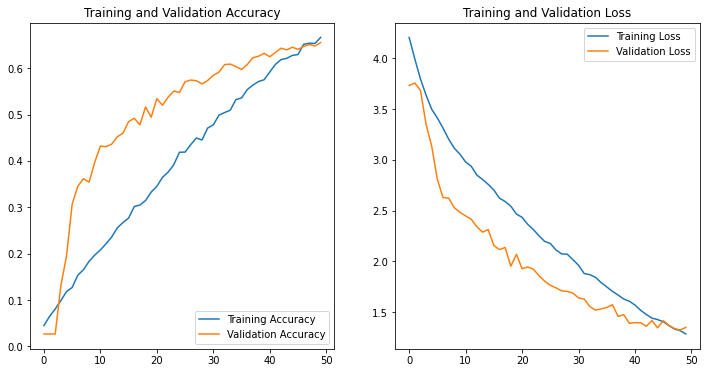

In [22]:
history = history_1

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Save a Model
model_1.save('models/freesound_model_v03_50.h5')

### Model 4 - Transfer Learning
One other approach I took warrants mention - training on the spectrgram dataset using transfer learning with the ResNet50 neural network from keras.

In [24]:
# Load the ResNet50 model
ResNet50_conv = ResNet50(weights='imagenet', include_top=False, input_shape=(50,75,3))
for layer in ResNet50_conv.layers:
    layer.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [25]:
# This time I used EarlyStopping to stop the model from training once it ceases to learn anything new, and then used ModelCheckpoint to save the model at that point.
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../models/freesound_model_rn50_best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [26]:
# Design Network
model_2 = Sequential([
    ResNet50_conv,
    Flatten(),
    Dense(1024),
    Dropout(0.2),
    Dense(512),
    Dropout(0.4),
    Dense(256),
    Dropout(0.6),
    Dense(41, activation='softmax')
])

# Show model summary
model_2.summary()

# Define optimizer
sgd = keras.optimizers.SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)

# Compile the model
model_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 3, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              12583936  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

#### Train the model

In [27]:
%%time 

epochs = 10

history_2 = model_2.fit(training_gen, steps_per_epoch=tr_batches, validation_data = validation_gen, validation_steps=va_batches, verbose=1, epochs=epochs)

Epoch 1/10
119/119 [==============================] - 36s 262ms/step - loss: 9.5134 - accuracy: 0.1218 - val_loss: 5.5874 - val_accuracy: 0.0306
Epoch 2/10
119/119 [==============================] - 31s 260ms/step - loss: 3.9032 - accuracy: 0.2612 - val_loss: 4.1512 - val_accuracy: 0.0301
Epoch 3/10
119/119 [==============================] - 31s 261ms/step - loss: 2.8208 - accuracy: 0.3622 - val_loss: 3.9922 - val_accuracy: 0.0301
Epoch 4/10
119/119 [==============================] - 31s 262ms/step - loss: 2.2034 - accuracy: 0.4669 - val_loss: 4.3200 - val_accuracy: 0.0301
Epoch 5/10
119/119 [==============================] - 31s 261ms/step - loss: 2.1411 - accuracy: 0.4981 - val_loss: 6.3788 - val_accuracy: 0.0301
Epoch 6/10
119/119 [==============================] - 31s 260ms/step - loss: 1.5688 - accuracy: 0.5852 - val_loss: 5.5481 - val_accuracy: 0.0348
Epoch 7/10
119/119 [==============================] - 31s 262ms/step - loss: 1.3521 - accuracy: 0.6392 - val_loss: 3.6673 - val_ac

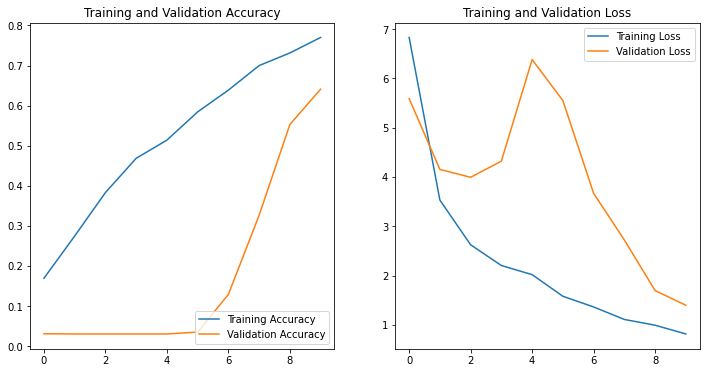

In [28]:
history = history_2

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Future Improvements

- Hyperparameter Tuning on the following hyperparameters: 
    - fmin/fmax (min/max of frequency)
    - n_mels (number of frequency bands)
    - n_fft (window length for each time section)
    - hop_length (number of samples to slide the window per step)
    
- Augementations to Spectrograms
    - Some image augmentation methods can't apply to spectrgram images as the would to regular images. For instance, if we had a dataset of dog pictures, we could rotate, crop and       mix up the image, but it would still be a dog. If we were to (let's say) rotate a spectrogram image, it changes the sound itself and it's no longer the sound we are trying         predict. This is due to the nature of spectrogram images. But we can still apply masks to the spectrgram over frequency and time, so this would be useful to do.
    
- Although I'm skeptical that it would benefit much in this project, there are other waveform image conversion types besides spectrograms that could be considered. The best one would probably be MFCC, which is very similar to Mel Spectrograms, but MFCC's are better at capturing timbre and other textural elements of sound. 

- Ensembling multiple pre-trained CNN's with deeper architectures. 